# Rollout and k-Rollout

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util.alg_perf import *
from util.guided_ot import *

In [2]:
# def find_intermediate_path(SC, partial, curr, ref_path, start, end, alpha):
#     ref_prefix = [curr] + partial[1:][::-1] if (len(partial) > 1) else [curr]
#     p_ref_nodes = ref_prefix + ref_path.nodes 
#     p_ref_w_prefix = Trajectory(SC, p_ref_nodes, 0)
#     ref_proj_w_prefix = p_ref_w_prefix.edge_projections[-1] 
#     remainder,_,_,_,_ = augmented_dijkstra(SC, curr, end, ref_proj_w_prefix, alpha, False, 0)
#     path_u = Trajectory(SC, partial + remainder.nodes)
#     return path_u

# def get_path_cost(path, ref_path, alpha):
#     path_len = path.path_length[-1]
#     path_proj = path.edge_projections[-1]
#     ref_proj = ref_path.edge_projections[-1]
#     cost = path_len + alpha * np.linalg.norm(path_proj - ref_proj, ord=1)
#     return cost

# def rollout_rec(SC, partial, curr_node, ref_path, alpha, start, end, depth, max_depth):
#     print("curr node:", curr_node)
#     if curr_node == end:
#         print(partial)
#         print(curr_node)
#         path = Trajectory(SC, partial + [curr_node], 0)
#         cost = get_path_cost(path, ref_path, alpha)
#         print("Path returned:", path)
#         print("Path cost:", cost)
#         return path, cost

#     elif depth == max_depth:
#         path = find_intermediate_path(SC, partial, curr_node, ref_path, start, end, alpha)
#         cost = get_path_cost(path, ref_path, alpha)
#         print("Path returned:", path)
#         print("Path cost:", cost)
#         return path, cost

#     path_options = []
#     costs = []
    
#     print(list(SC.graph.neighbors(curr_node)))
#     for v in SC.graph.neighbors(curr_node):
#         #partial_u = partial + [curr_node]
#         print("partial:", partial)
#         path_v, cost_path_v = rollout_rec(SC, partial, v, ref_path, alpha, start, end, depth+1, max_depth)
#         path_options += [path_v]
#         costs += [cost_path_v]
#         print("node:", v, ", cost:", cost_path_v)


#     best_cost, best_idx = np.min(np.array(costs)), np.argmin(np.array(costs))
#     best_path = path_options[best_idx]

#     return best_path, best_cost


# def k_rollout(SC, ref_path, alpha, max_depth):
#     start, end = ref_path.nodes[0], ref_path.nodes[-1]
#     vk = start
#     path = [start]

#     ref_class = Trajectory_Class(SC)
#     ref_class.add_path(ref_path)
#     best_costs, best_paths = [], []
#     best_paths = []

#     k=0
#     print('vk =', vk)
#     while vk != end:
#         path_vk, cost_vk = rollout_rec(SC, path, vk, ref_path, alpha, start, end, 0, max_depth)
#         vk = path_vk.nodes[k+1]
#         path += [vk]
#         best_paths += [path_vk]
#         best_costs += [cost_vk]
#         k+=1 
#         print("-"*200)
#         print('vk =', vk)

#     return Trajectory(SC, path, 0), best_costs, best_paths

In [3]:
def find_intermediate_path(SC, partial, ref_path, end, alpha):
    #ref_prefix = [curr] + partial[1:][::-1] if (len(partial) > 1) else [curr]
    ref_prefix = partial[1:][::-1]
    p_ref_nodes = ref_prefix + ref_path.nodes 
    p_ref_w_prefix = Trajectory(SC, p_ref_nodes, 0)
    ref_proj_w_prefix = p_ref_w_prefix.edge_projections[-1] 
    curr = partial[-1]
    remainder,_,_,_,_ = augmented_dijkstra(SC, curr, end, ref_proj_w_prefix, alpha, False, 0)
    path_u = Trajectory(SC, partial + remainder.nodes[1:])
    return path_u

def get_path_cost(path, ref_path, alpha):
    path_len = path.path_length[-1]
    path_proj = path.edge_projections[-1]
    ref_proj = ref_path.edge_projections[-1]
    cost = path_len + alpha * np.linalg.norm(path_proj - ref_proj, ord=1)
    return cost

def rollout_rec(SC, partial, curr_node, ref_path, alpha, start, end, depth, max_depth):
    if curr_node == end:
        path = Trajectory(SC, partial, 0)
        cost = get_path_cost(path, ref_path, alpha)
        return path, cost

    elif depth == max_depth:
        path = find_intermediate_path(SC, partial, ref_path, end, alpha)
        cost = get_path_cost(path, ref_path, alpha)
        return path, cost

    path_options = []
    costs = []
    
    for v in SC.graph.neighbors(curr_node):
        path_v, cost_path_v = rollout_rec(SC, partial + [v], v, ref_path, alpha, start, end, depth+1, max_depth)
        path_options += [path_v]
        costs += [cost_path_v]
        print(v, cost_path_v)

    best_cost, best_idx = np.min(np.array(costs)), np.argmin(np.array(costs))
    best_path = path_options[best_idx]

    return best_path, best_cost


def k_rollout(SC, ref_path, alpha, max_depth):
    start, end = ref_path.nodes[0], ref_path.nodes[-1]
    vk = start
    path = [start]

    ref_class = Trajectory_Class(SC)
    ref_class.add_path(ref_path)
    best_costs, best_paths = [], []

    k=0
    print('vk =', vk)
    while vk != end:
        path_vk, cost_vk = rollout_rec(SC, path, vk, ref_path, alpha, start, end, 0, max_depth)
        vk = path_vk.nodes[k+1]
        path += [vk]
        best_paths += [path_vk]
        best_costs += [cost_vk]
        k+=1 
        print("-"*200)
        print('vk =', vk)

    return Trajectory(SC, path, 0), best_costs, best_paths

# Define domain

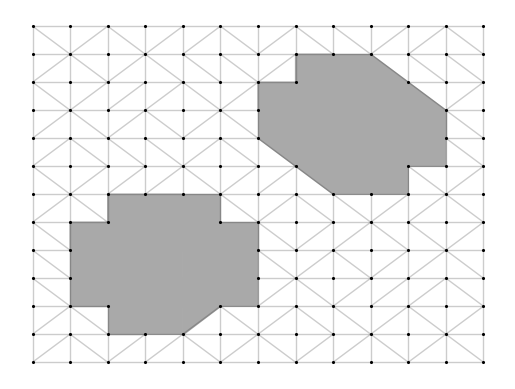

In [4]:
n_side, point_gen_mode = 13, 0

r1, r2 = 0.6, 0.3
n_holes = 2
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
SC.plot()


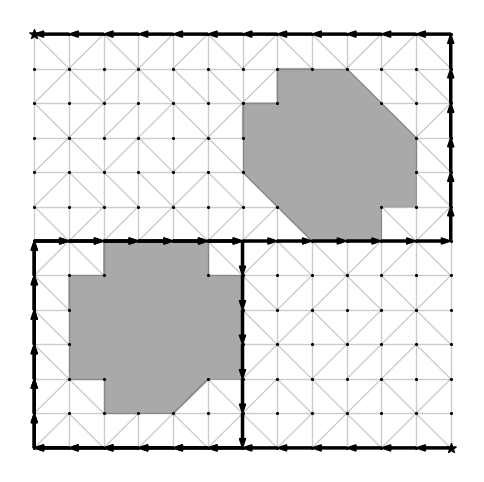

In [5]:
coords = np.array([(1,-1,), (-1, -1,), (-1, 0), (0,0), (0,-1), (-1, -1), (-1,0), (1, 0), (1,1), (-1, 1)])
ref_path, ref_path_class, path_proj, _ = path_from_coords(SC, coords, 'black', True)
start, end = ref_path.nodes[0], ref_path.nodes[-1]
ref_class = Trajectory_Class(SC, False)
ref_class.add_path(ref_path)

In [6]:
ref_proj = ref_path.edge_projections[-1]
shortest_path ,_,_,_,_ = augmented_dijkstra(SC, start, end, ref_proj, 0, False, 0)
shortest_path

12-24-36-49-62-74-86-98-110-122-134-133-132-144-156

# Rollout Test 1

In [ ]:
alpha, k = 10, 2
path_krollout2, best_kcosts2, best_kpaths2 = k_rollout(SC, ref_path, alpha, k)
path_krollout0, best_kcosts0, best_kpaths0 = k_rollout(SC, ref_path, alpha, 0)
dijkstra_tree(SC, path_krollout2, [path_krollout0], ref_class, plot_others=True)

In [ ]:
print(ref_path.edge_projections)

In [ ]:
ref_path.edge_projections.shape, path_krollout2.edge_projections.shape, path_krollout0.edge_projections.shape

vk = 12
11 33.16966295301237
24 33.30773414047007
25 33.21010306753229
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vk = 11
10 33.16966295301237
12 33.502996286345706
24 33.40536521340788
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vk = 10
9 33.16966295301237
11 33.502996286345706
24 33.6410674738034
23 33.40536521340788
22 33.30773414047006
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vk = 9
8 33.16966295301237
10 33.502996286345706
22 33.40536521340788
------------------------------------------------------------------------

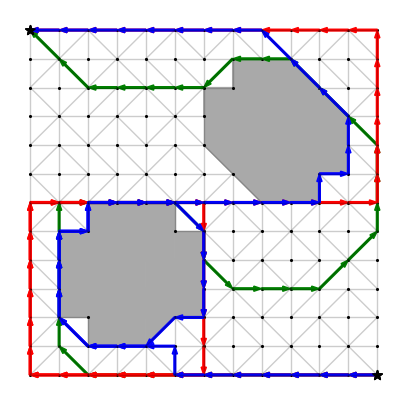

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


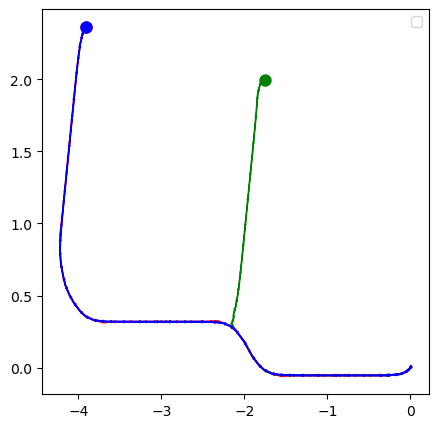

In [7]:
alpha, k = 10, 1
path_krollout1, best_kcosts1, best_kpaths1 = k_rollout(SC, ref_path, alpha, k)
dijkstra_tree(SC,  path_krollout1, [best_kpaths1[0]], ref_class, plot_others=True)

In [ ]:
alpha, k = 100, 2
path_krollout, best_kcosts, best_kpaths = k_rollout(SC, ref_path, alpha, 0)
dijkstra_tree(SC, best_kpaths[0], [best_kpaths1[0]], ref_class, plot_others=True) 
print()

# Rollout test 2

12-24-36-49-62-74-86-98-110-122-134-133-132-144-156

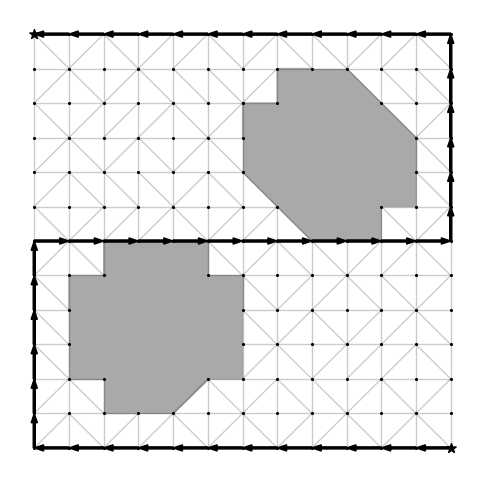

In [55]:
coords = coords = np.array([(1,-1,), (-1, -1,), (-1, 0), (1, 0), (1,1), (-1, 1)])
ref_path, ref_path_class, path_proj, _ = path_from_coords(SC, coords, 'black', True)
start, end = ref_path.nodes[0], ref_path.nodes[-1]
ref_class = Trajectory_Class(SC, False)
ref_class.add_path(ref_path)
ref_proj = ref_path.edge_projections[-1]
shortest_path ,_,_,_,_ = augmented_dijkstra(SC, start, end, ref_proj, 0, False, 0)
shortest_path

vk = 12
11 3.121320343559642
24 3.023689270621825
25 3.121320343559642
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vk = 24
10 3.2593915310173407
11 3.3570226039551576
12 3.495093791412856
23 3.121320343559642
25 3.3570226039551585
38 3.2593915310173407
37 3.121320343559642
36 3.023689270621825
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vk = 36
22 3.2593915310173407
23 3.3570226039551576
24 3.4950937914128564
35 3.121320343559642
37 3.3570226039551576
49 3.0236892706218246
50 3.2593915310173407
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

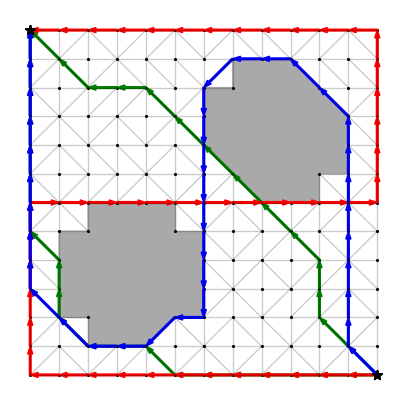

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


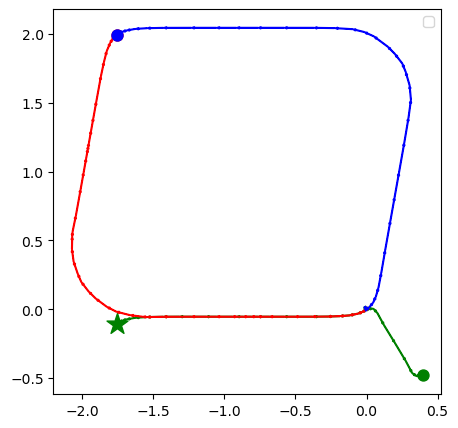

In [57]:
alpha1, alpha2, alpha3 = 0, 0.785, 1.41
k = 1
path_krollout1, best_kcosts1, best_kpaths1 = k_rollout(SC, ref_path, alpha1, k)
path_krollout2, best_kcosts2, best_kpaths2 = k_rollout(SC, ref_path, alpha2, k)
path_krollout3, best_kcosts3, best_kpaths3 = k_rollout(SC, ref_path, alpha3, k)
dijkstra_tree(SC, path_krollout3, [path_krollout1, path_krollout2], ref_class, plot_others=True)

In [ ]:
print(np.linalg.norm(ref_path.edge_projections[-1] - path_krollout1.edge_projections[-1], ord=1))
print(path_krollout1.path_length[-1], path_krollout3.path_length[-1])
dijkstra_tree(SC, path_krollout3, [path_krollout1], ref_class, plot_others=True)

In [ ]:
print(np.linalg.norm(ref_path.edge_projections[-1] - path_krollout2.edge_projections[-1], ord=1))
print(path_krollout2.path_length[-1], path_krollout3.path_length[-1])
dijkstra_tree(SC, path_krollout3, [path_krollout2], ref_class, plot_others=True)

In [ ]:
w1_diff = path_krollout3.path_length[-1] - path_krollout1.path_length[-1]
w2_diff = path_krollout3.path_length[-1] - path_krollout2.path_length[-1]
w3_diff = path_krollout3.path_length[-1] - path_krollout3.path_length[-1]
p1_diff = np.linalg.norm(path_krollout1.edge_projections[-1] - ref_path.edge_projections[-1], ord=1)
p2_diff = np.linalg.norm(path_krollout2.edge_projections[-1] - ref_path.edge_projections[-1], ord=1)
p3_diff = np.linalg.norm(path_krollout3.edge_projections[-1] - ref_path.edge_projections[-1], ord=1)
alpha_star1 = w1_diff / p1_diff
alpha_star2 = w2_diff / p2_diff
alpha_star3 = w3_diff / p3_diff

print([alpha_star1, alpha_star2, alpha_star3])

In [ ]:
alpha = 2
path_rollout1, best_costs1, best_paths1 = rollout(SC, ref_path, alpha)
dijkstra_tree(SC, path_rollout1, [best_paths1[0]], ref_class, plot_others=True)

In [ ]:
alpha = 2
path_rollout1, best_costs1, best_paths1 = rollout(SC, ref_path, alpha)
dijkstra_tree(SC, path_rollout1, [best_paths1[2]], ref_class, plot_others=True)

In [ ]:
plt.plot(best_costs1)
plt.show()

In [ ]:
alpha = 100
path_rollout2, best_costs2, best_paths2 = rollout(SC, ref_path, alpha)
dijkstra_tree(SC, path_rollout2, [best_paths2[2]], ref_class, plot_others=True)

In [ ]:
plt.scatter(np.arange(len(best_costs1)), best_costs1, marker=".")
plt.scatter(np.arange(len(best_costs2)), best_costs2, marker=".")
plt.legend(["alpha=2", "alpha=100"])
plt.xlabel("Iteration")
plt.ylabel("Path Cost")
plt.show()

In [ ]:
alpha = 0
path_rollout = rollout(SC, start, end, ref_path, alpha)

In [ ]:
alpha = 1
path_rollout = rollout(SC, start, end, ref_path, alpha)

In [ ]:
alpha = 4
path_rollout = rollout(SC, start, end, ref_path, alpha)